Project Goal 
Recommend top 5 products with 50 and 100 minimum interactions based on popularity

In [1]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error 

In [2]:
# Import the dataset
file_path = '/Users/zacw/Downloads/ratings_Electronics.csv'

df = pd.read_csv(file_path, header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

In [3]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [4]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [5]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [6]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [7]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [8]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  65290
No of columns:  3


In [9]:
# Check data types
data_types = df_final.dtypes

# Provide observations
print("Data Types:")
print(data_types)

Data Types:
user_id     object
prod_id     object
rating     float64
dtype: object


In [10]:
# Check for missing values 
missing_values = df_final.isnull().sum()

# Provide observations
print("Missing Values:")
print(missing_values)

Missing Values:
user_id    0
prod_id    0
rating     0
dtype: int64


In [11]:
# Summary statistics of 'rating' variable and provide observations
# Calculate summary statistics for the 'rating' variable
rating_stats = df_final['rating'].describe()

# Provide observations
print("Summary Statistics for 'rating' Variable:")
print(rating_stats)

Summary Statistics for 'rating' Variable:
count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


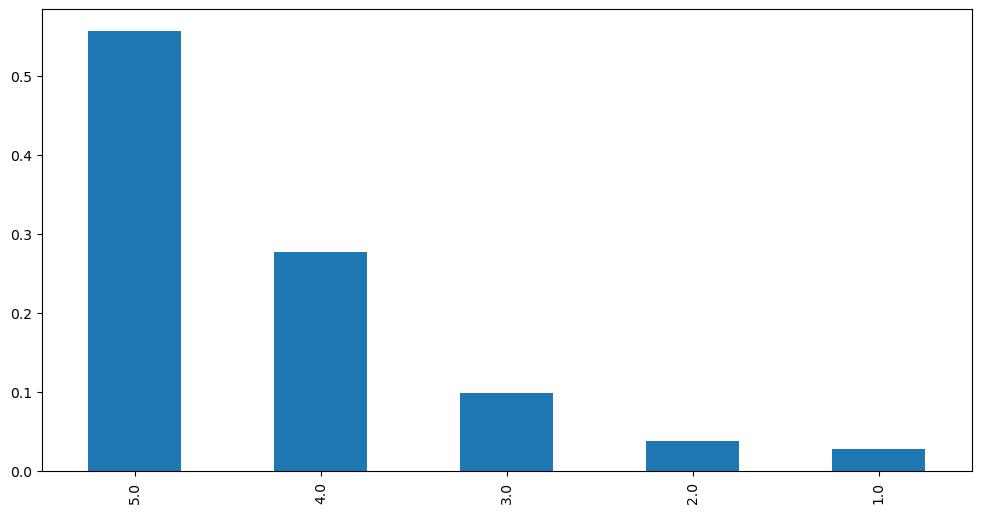

In [12]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(1).plot(kind='bar')

plt.show()

over 50% are 5-star rating

In [13]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


In [14]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

In [15]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


build the first recommendation system

In [16]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating': average_rating, 'Rating_Count': count_rating})

# Sort the DataFrame by the average of ratings in descending order
final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,Average_Rating,Rating_Count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [17]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    # Finding products with minimum number of interactions
    min_interaction_products = final_rating[final_rating['Rating_Count'] >= min_interaction]
    
    # Sorting values with respect to average rating in descending order
    sorted_recommendations = min_interaction_products.sort_values(by='Average_Rating', ascending=False)
    
    # Return the top N products' indices
    return sorted_recommendations.index[:n]

Recommending top 5 products with 50 minimum interactions based on popularity

In [18]:
n = 5  # Number of top products to recommend
min_interaction = 50  # Minimum interactions

# Use the top_n_products function to get the recommendations
top_popular_products = top_n_products(final_rating, n, min_interaction)

# Print the recommended product indices
print("Top 5 popular products with a minimum of 50 interactions:")
print(top_popular_products)

Top 5 popular products with a minimum of 50 interactions:
Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')


Recommending top 5 products with 100 minimum interactions based on popularity

In [19]:
n = 5  # Number of top products to recommend
min_interaction = 100  # Minimum interactions

# Use the top_n_products function to get the recommendations
top_popular_products = top_n_products(final_rating, n, min_interaction)

# Print the recommended product indices
print("Top 5 popular products with a minimum of 100 interactions:")
print(top_popular_products)

Top 5 popular products with a minimum of 100 interactions:
Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')


This is based on the popularity recommendation system.